In [1]:
import numpy as np
import pandas as pd
import glob

from os.path import expanduser
home = expanduser("~")

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
path = home + '/vvm/servers/*'

cpu_usage = [pd.read_csv(f) for f in glob.glob(path + '/jvm.process.cpu.seconds.csv')]
mem_usage = [pd.read_csv(f) for f in glob.glob(path + '/memory.heap.usage.csv')]
thread_count = [pd.read_csv(f) for f in glob.glob(path + '/threads.count.csv')]

for i in range(len(cpu_usage)):
    cpu_usage[i]['t'] -= cpu_usage[i]['t'][0]
    cpu_usage[i]['value'] *= 100
    
    mem_usage[i]['t'] -= mem_usage[i]['t'][0]
    mem_usage[i]['value'] *= 100
    
    thread_count[i]['t'] -= thread_count[i]['t'][0]

In [3]:
def averaged_df(df_list, column_index):
    x = np.array(df_list[0][column_index][0:-1])
    for i in range(1, len(df_list)):
        n = np.array(df_list[i][column_index])
        x_s, n_s = x.shape[0], n.shape[0]
        if (n_s < x_s):
            x.resize(n_s)
        else:
            n.resize(x_s)
        x += n
    return x / len(df_list)

def spline(y):
    xp = np.linspace(0, len(y) - 1, 10000) 
    spl = make_interp_spline(np.arange(0, len(y)), y, k=3)
    smooth = spl(xp)
    return xp, smooth

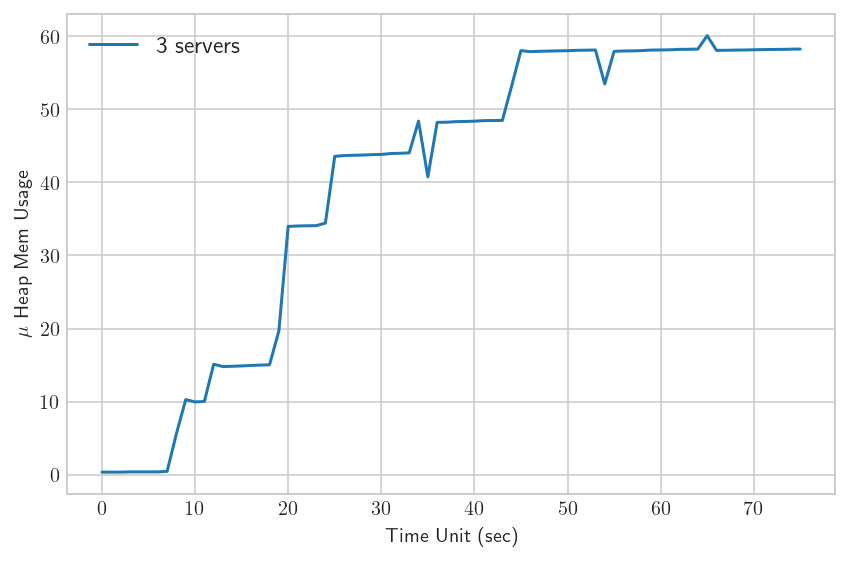

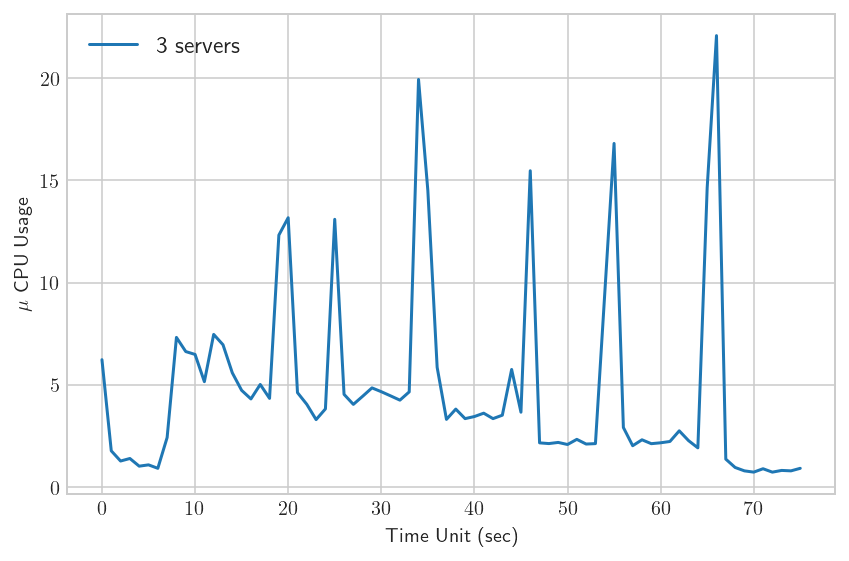

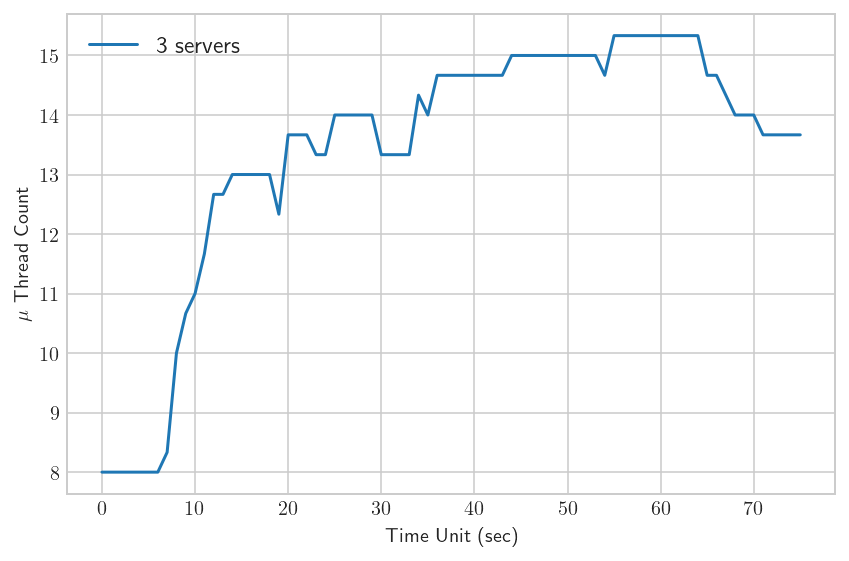

In [4]:
# Mem Usage

plt.figure(figsize=(6, 4))
y_averaged_mem = averaged_df(mem_usage, 'value')
plt.plot(y_averaged_mem, label=f'{len(mem_usage)} servers')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ Heap Mem Usage')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-mem-usage.pdf', bbox_inches='tight')
plt.show();

# CPU Usage

plt.figure(figsize=(6, 4))
y_averaged_cpu = averaged_df(cpu_usage, 'value')
plt.plot(y_averaged_cpu, label=f'{len(cpu_usage)} servers')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ CPU Usage')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-cpu-usage.pdf', bbox_inches='tight')
plt.show();

# Thread Count

plt.figure(figsize=(6, 4))
y_averaged_threads = averaged_df(thread_count, 'value')
plt.plot(y_averaged_threads, label=f'{len(thread_count)} servers')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ Thread Count')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-thread-count.pdf', bbox_inches='tight')
plt.show();